In [56]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random as rng
import math


In [57]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

def to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def warp_perspective(img,mat):
    return cv2.warpPerspective(img ,mat ,(1280,720))
    
def PerspectiveTransform(src,dst):
    mat = cv2.getPerspectiveTransform(src,dst)
    mat_inv = cv2.getPerspectiveTransform(dst,src)
    return mat,mat_inv

def isolate_color_mask(img, low_thresh, high_thresh):
    return cv2.inRange(img, low_thresh, high_thresh)


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img


def concat_frames(frames):
    
    scale_percent = 0.2
    height = int(frames[0].shape[0] * 0.5)
    width = int(frames[0].shape[1] * scale_percent)
    dim = (width, height)
    img = cv2.resize(frames[0], dim, interpolation = cv2.INTER_AREA)
    img2= cv2.resize(cv2.cvtColor(frames[5], cv2.COLOR_GRAY2BGR), dim, interpolation = cv2.INTER_AREA)
        
    for i in range(1,len(frames)):
        
        try:
            
            frames[i] = cv2.cvtColor(frames[i], cv2.COLOR_GRAY2BGR)
        except:
            pass
        
        if(i==5):
            continue
        
        try:
            resized = cv2.resize(frames[i], dim, interpolation = cv2.INTER_AREA)
            if i< (len(frames)/2):
                img = cv2.hconcat([img,resized])
            else:
                img2 = cv2.hconcat([img2,resized])
        except:
            pass
    
    t = cv2.vconcat([img,img2])
            
            

            
    
    return t


def get_right(image):
    cropped_img=np.zeros_like(image)
    cropped_img[:,image.shape[1]//2:image.shape[1]] = image[:,image.shape[1]//2:image.shape[1]]
    return cropped_img

def get_left(image):
    cropped_img=np.zeros_like(image)
    cropped_img[:,0:image.shape[1]//2] = image[:,0:image.shape[1]//2]
    return cropped_img

def calculateDistance(x1,y1,x2,y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist
        


def get_aoi(img):
    rows, cols = img.shape[:2]
    mask = np.zeros_like(img)
    
    left_bottom = [cols * 0.1, rows]
    right_bottom = [cols * 0.95, rows]
    left_top = [cols * 0.4, rows * 0.6]
    right_top = [cols * 0.6, rows * 0.6]
    
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255, ) * mask.shape[2])
    return cv2.bitwise_and(img, mask)
    

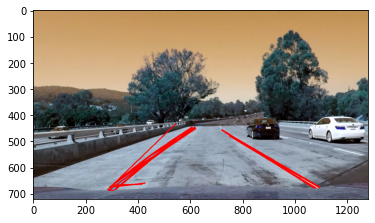

In [58]:
img=cv2.imread(r"Assets\Project_data\test_images\test1.jpg")


rows, cols = img.shape[:2]
mask = np.zeros_like(img)

input_top_left = [500,480]
input_top_right = [780,480]
input_bottom_right = [1200,700]
input_bottom_left = [170,700]
srcPts = np.float32([input_bottom_left,input_top_left,input_top_right,input_bottom_right])
dstPts = np.float32([[0,720],[0,0],[1280,0],[1280,720]])



mat,mat_inv = PerspectiveTransform(srcPts,dstPts)
bird_view = warp_perspective(img,mat)

gray_img = grayscale(bird_view)
darkened_img = adjust_gamma(gray_img, 0.5)
white_mask = isolate_color_mask(to_hls(img), np.array([0, 200, 0], dtype=np.uint8), np.array([200, 255, 255], dtype=np.uint8))
yellow_mask = isolate_color_mask(to_hls(img), np.array([10, 0, 100], dtype=np.uint8), np.array([40, 255, 255], dtype=np.uint8))
mask = cv2.bitwise_or(white_mask, yellow_mask)
colored_img = cv2.bitwise_and(darkened_img, darkened_img, mask=mask)
blurred_img = gaussian_blur(colored_img, kernel_size=7)


edges = cv2.Canny(blurred_img,70,140)

aoi_img = get_aoi(edges)

lines =cv2.HoughLinesP(aoi_img,1,np.pi/180,20,minLineLength=20,maxLineGap=300)
hough_img = draw_lines(img, lines)


plt.imshow(hough_img)


In [59]:
left = tuple()
right = tuple()
top = tuple()
bottom = tuple()

old_pts=[]

In [60]:
cap = cv2.VideoCapture(r"Assets\Project_data\project_video.mp4")

counter = 0
while cap.isOpened():
  ret,img = cap.read()
  if not ret:
      break
    
  
    
  mat,mat_inv = PerspectiveTransform(srcPts,dstPts)
  bird_view = warp_perspective(img,mat)
  bird_cpy = bird_view.copy()
  gray_img = grayscale(bird_view)
  darkened_img = adjust_gamma(gray_img, 0.5)
  white_mask = isolate_color_mask(to_hls(bird_view), np.array([0, 200, 0], dtype=np.uint8), np.array([200, 255, 255], dtype=np.uint8))
  yellow_mask = isolate_color_mask(to_hls(bird_view), np.array([10, 0, 100], dtype=np.uint8), np.array([40, 255, 255], dtype=np.uint8))
  mask = cv2.bitwise_or(white_mask, yellow_mask)
  colored_img = cv2.bitwise_and(darkened_img, darkened_img, mask=mask)
  blurred_img = gaussian_blur(colored_img, kernel_size=7)
  edges = cv2.Canny(mask,70,140)
  edges = cv2.dilate(edges,np.ones((7,7)))  
  contours,_= cv2.findContours(get_left(edges), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  
  c = max(contours, key=cv2.contourArea)
  

    
  
  left = tuple(c[c[:, :, 0].argmin()][0])
  right = tuple(c[c[:, :, 0].argmax()][0])
  top = tuple(c[c[:, :, 1].argmin()][0])
  bottom = left[0] + right[0]-top[0] , left[1]
  points = np.array([bottom,right,top,left])

  #   for i,pt in enumerate(points) :
  #     if calculateDistance(pt[0],pt[1],old_pts[i][0],old_pts[i][1]) > 80 :
  #       points[i]= old_pts[i]
  #     else:
  #       old_pts=points
    
  # for i,pt in enumerate(points) :
  #   print(calculateDistance(pt[0],pt[1],old_pts[i][0],old_pts[i][1])) 
  

  
  cv2.fillConvexPoly(bird_cpy, points,color=(0,255, 0))
  
  
  contours,_= cv2.findContours(get_right(edges), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  cv2.drawContours(bird_cpy, contours, -1, (36, 255, 12), 2)
  
  
  c = max(contours, key=cv2.contourArea)
    
  
  r_left = tuple(c[c[:, :, 0].argmin()][0])
  r_right = tuple(c[c[:, :, 0].argmax()][0])
  r_top = r_right[0],r_left[1]
  r_bottom = tuple(c[c[:, :, 1].argmax()][0])
  
  points = np.array([r_bottom,r_right,r_top,r_left])
    
  # cv2.circle(bird_cpy, r_left, 8, (0, 50, 255), -1)
  # cv2.circle(bird_cpy, r_right, 8, (0, 255, 255), -1)
  # cv2.circle(bird_cpy, r_top, 8, (255, 50, 0), -1)
  # cv2.circle(bird_cpy, r_bottom, 8, (255, 255, 0), -1)
  
  
  RL_U = r_left[0],top[1]
  RL_D = r_bottom[0],bottom[1]
  
  
  pts=np.array([RL_U,RL_D,bottom,right])
  
  

  # pts=np.array([bottom,right,top,left])

    
  cv2.fillConvexPoly(bird_cpy, pts,color=(255, 0, 0))
  
  
  
  cv2.fillConvexPoly(bird_cpy, points,color=(0,255, 0))
  
  
  
  
  cv2.drawContours(bird_view, c, -1, (0, 255, 0), 5, cv2.LINE_AA)

  
  
  

  # lines =cv2.HoughLinesP(edges,1,np.pi/180,20,minLineLength=50,maxLineGap=300)
  # try: 
  #   hough_img = draw_lines(bird_view, lines)
  # except:
  #   pass
    
  re_gen = warp_perspective(bird_cpy,mat_inv)
  

  
  # cv2.imshow("fgg",re_gen)
  
  imgg = img.copy()
  cv2.addWeighted(img, 0.5, re_gen, 0.5,0, imgg)
  pipeline=[img,bird_cpy,gray_img,darkened_img,mask,colored_img,blurred_img,edges,bird_view,imgg]
  
  t=concat_frames(pipeline)
  
  counter+=1
  
  cv2.imshow("fgg",t)
  

    
  if cv2.waitKey(25) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()
